# Hamiltonian Monte Carlo

#### Theory
With reference to [Stan Reference Manual](https://mc-stan.org/docs/reference-manual/hamiltonian-monte-carlo.html).



- The goal is to draw samples from a target distribution $p(\theta)$ for parameters $\theta$. (Dian uses $\rho(\theta)$ for the probability distribution)

- HMC introduces auxilary momentum variables $\rho$, this auxilary density $\rho$ is a multivariate normal and is independent of $\theta$.

    - $\rho \sim MultiNormal(\underline{0}, M)$, where $M$ is the [Euclidean metric](https://mathworld.wolfram.com/EuclideanMetric.html).

        - eg. a 2D Gaussian $p(\textbf{x}) = \mathcal{N}(\textbf{x};\begin{bmatrix} 0 \\ 0 \end{bmatrix},\begin{bmatrix} 1 & 0.98 \\ 0.98 & 1 \end{bmatrix})$

- The Hamiltonian $H(\rho,\theta)= kinetic \ energy + potential \ energy$

    - $kinetic \ energy = K (\rho \mid \theta) = - \log p(\rho \mid \theta)$

    - $potential \ energy = U(\theta) = -\log p(\theta)$

    - $\frac{d\theta}{dt} = -\frac{\partial T}{\partial \rho}$
    
    - $\frac{d\rho}{dt} = -\frac{\partial U}{\partial \theta}$

**Leapfrog integrator**

For small time inteval $\epsilon$, it updates the $\rho$ and $\theta$ as follows:
- $$\rho \leftarrow \rho - \frac{\epsilon}{2} \frac{\partial U}{\partial \theta}$$
- $$\theta \leftarrow \theta + \epsilon M^{-1} \rho$$
- $$\rho \leftarrow \rho - \frac{\epsilon}{2} \frac{\partial U}{\partial \theta}$$

After the orbit is integrated for a while, a new proposed sample is generated, and accepted or rejected,
then a new random momentum is generated and the procedure repeated.

## Parameters

With reference to [Stan Reference Manual](https://mc-stan.org/docs/reference-manual/hmc-algorithm-parameters.html)

The Hamiltonian Monte Carlo algorithm has three parameters which must be set,

- discretization time $\epsilon$
- metric $M$
- number of leapfrog steps taken $L$

$H(\rho, \theta) =  U(\theta) + K(\rho)$

#### **Pseudo code**
Copying from [HMC Handbook, Chapter 5, Page 125](https://www.mcmchandbook.net/HandbookChapter5.pdf)

At which $q$ is the same as the "postition" $\theta$, and $p$ is the same as the "momentum" $\rho$

$\rightarrow$ $H(q, p) = H(\rho, \theta) =  U(q) + K(p)$

    HMC = function (U, grad_U, epsilon, L, current_q)
    {
        q = current_q
        p = rnorm(length(q),0,1) # independent standard normal variates
        current_p = p

        # Make a half step for momentum at the beginning
        p=p- epsilon * grad_U(q) / 2

        # Alternate full steps for position and momentum

        for (i in 1:L)
        {
            # Make a full step for the position
            q=q+ epsilon * p
            # Make a full step for the momentum, except at end of trajectory
            if (i!=L)p=p- epsilon * grad_U(q)
        }

        # Make a half step for momentum at the end.
        p=p- epsilon * grad_U(q) / 2
        # Negate momentum at end of trajectory to make the proposal symmetric
        p = -p

        # Evaluate potential and kinetic energies at start and end of trajectory
        current_U = U(current_q)
        current_K = sum(current_pˆ2) / 2
        proposed_U = U(q)
        proposed_K = sum(pˆ2) / 2

        # Accept or reject the state at end of trajectory, returning either
        # the position at the end of the trajectory or the initial position

        if (runif(1) < exp(current_U-proposed_U+current_K-proposed_K))
        {
            return (q) # accept
        }
        else
        {
            return (current_q) # reject
        }
    }

In [12]:
import numpy as np

def HMC(epoch, L, epsilon, U, grad_U, current_theta):

    """
    
    Hamiltonian Monte Carlo algorithm

    Parameters
    ----------
    epoch: number of iteration of the algorithm
    L: number of steps of leap frog
    epsilon: step size for discrete approximation
    U: potential energy
    grad_U: derivative of potential energy
    current_theta: the current 'position'
    
    Returns
    -------
    theta_accept: if accpeted
    theta_reject: if rejected

    
    """

    theta_accept = []
    theta_reject = []
    
    for _ in range(epoch):
    
        theta = current_theta
        rho = np.random.normal(loc = 0, scale = 1, size= len(theta)) # sample random momentum
        current_rho = rho
        
        # make a half step for momentum at the beginning
        rho = rho - epsilon * grad_U(theta) / 2 

        # alternate full steps for position and momentum
        for i in range(1, L):

            #make a full step for the position
            theta = theta + epsilon * rho

            #make a full step for the momentum, except at end of trajectory
            if (i != L):
                rho = rho - epsilon * grad_U(theta)
        
        # make a half step for momentum at the end
        rho = rho - epsilon * grad_U(theta) / 2

        # Negate momentum at end of trajectory to make the proposal symmetric
        rho = -rho

        # Evaluate potential and kinetic energies at start and end of trajectory (K kinetic energy, U potential energy)
        current_U = U(current_theta)
        current_K = sum(current_rho**2) / 2
        proposed_U = U(theta)
        proposed_K = sum(rho**2) / 2

        # Accept or reject the state at end of trajectory, returning either
        # the position at the end of the trajectory or the initial position

        if (np.random.uniform(0, 1) < np.exp(current_U - proposed_U + current_K - proposed_K)):
            current_theta = theta
            #return (theta) # accept
            theta_accept.append(theta)
        else:
            theta_reject.append(current_theta)
            #return (current_theta) # reject

    return theta_accept, theta_reject

## Likelihood

Borrowing from 'MCMCAlgorithm_DIANZHANG.ipynb'.

In [2]:
from typing import List, Callable

class Likelihood_Gaussian:
    def __init__(self, Dim:int, Dataset: List[List[float]]) -> None:
        self.Dim = Dim
        self.Dataset = Dataset
    
    def f(self, x: List[float], mu: List[float]) -> float:
        res = 1
        for i in  range(0, self.Dim):
            res *= (np.exp(-((x[i]-mu[i])**2)/2))/(np.sqrt(2*np.pi))
        return res

    def L(self, mu: List[float]) -> float:
        res = 1
        for i in range(len(self.Dataset)):
            res *= self.f(self.Dataset[i], mu)
        return res
    
    def dLdmu(self, mu: List[float]) -> List[float]:
        res = self.L(mu)
        Res = []
        for i in range(len(mu)):
            subres = res
            for k in range(len(self.Dataset)):
                subres *= (self.Dataset[k][i]-mu[i])
            Res.append(subres)
        return Res

Data: $\mathcal{N}(\begin{bmatrix} 2 \\ 2 \end{bmatrix}, \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix})$

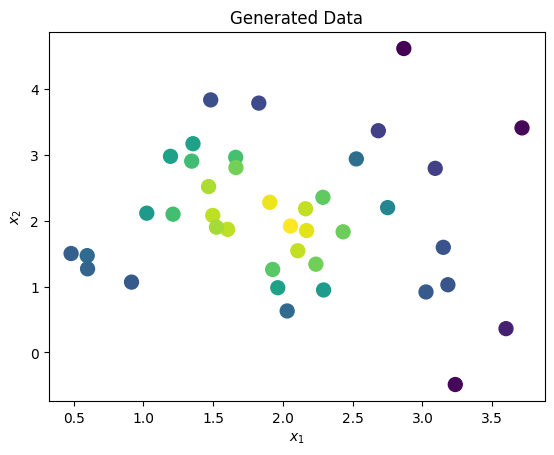

/var/folders/09/6kd4cffd1c91y_kc5vxpf0vc0000gn/T/ipykernel_59922/4020461533.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


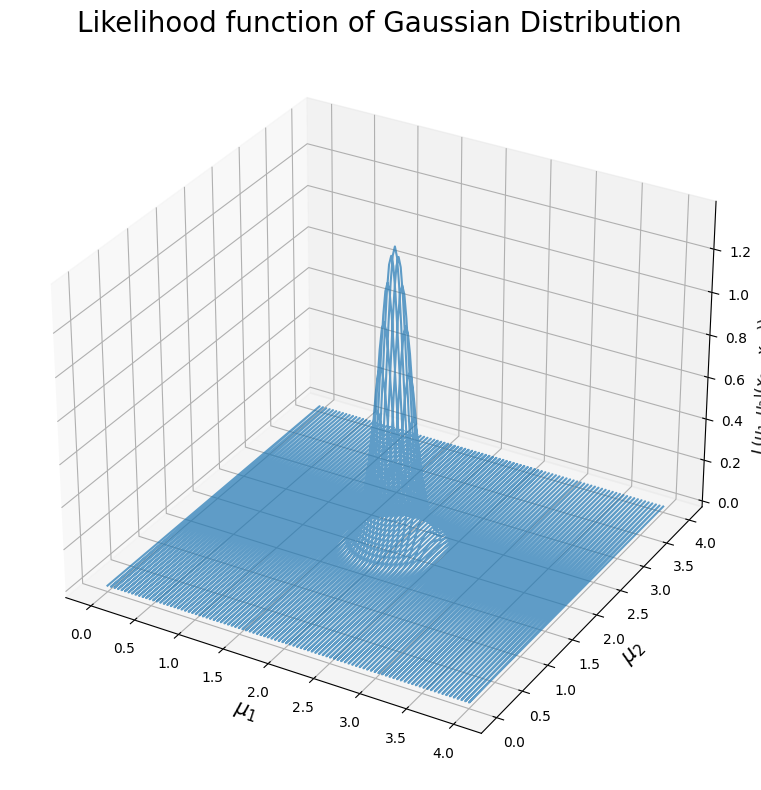

In [3]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

Dataset = []
for _ in range(0,40):
    Dataset.append(list(np.random.default_rng().normal(2, 1, 2)))

x1 = [p[0] for p in Dataset]
x2 = [p[1] for p in Dataset]
x1x2 = np.vstack([x1,x2])
z = gaussian_kde(x1x2)(x1x2)
plt.scatter(x1, x2, c=z, s=100)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Generated Data")
plt.show()

Likeli = Likelihood_Gaussian(Dim=2, Dataset=Dataset)
Grid = np.linspace(0, 4, 100)
x = []
y = []
z = []
r = len(Grid)
for g in Grid:
    y += list(Grid)
    x += [g]*r
    z += [Likeli.L([g, k]) for k in Grid]
fig = plt.figure(figsize=(8, 8), facecolor="white")
Gau = fig.add_subplot(projection="3d")
Gau.plot(x, y, z, alpha=0.7)
Gau.set_xlabel("$\mu_1$", fontsize=15)
Gau.set_ylabel("$\mu_2$", fontsize=15)
Gau.set_zlabel("$L(\mu_1, \mu_2| {(x_{1,i}, x_{2,i})})_{i \in \{1,..,40\}}$", fontsize=11)
Gau.set_title("Likelihood function of Gaussian Distribution", fontsize=20)
fig.tight_layout()
fig.show()

## Predict

In [4]:
def U(theta: List[float]) -> float: # the potential energy function: U(theta) = -log(probability distribution of theta)
    return (- np.log(Likeli.L(theta)))

def grad_U(theta: List[float]) -> float:
    DRho = Likeli.dLdmu(theta)
    Rho = Likeli.L(theta)*(-1)
    return np.array([DRho/Rho for DRho in DRho])

In [13]:
theta_accept, theta_reject = HMC(epoch=2000, L=20, epsilon=0.001, U=U, grad_U=grad_U, current_theta=[1, 1])

/var/folders/09/6kd4cffd1c91y_kc5vxpf0vc0000gn/T/ipykernel_59922/2821595686.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


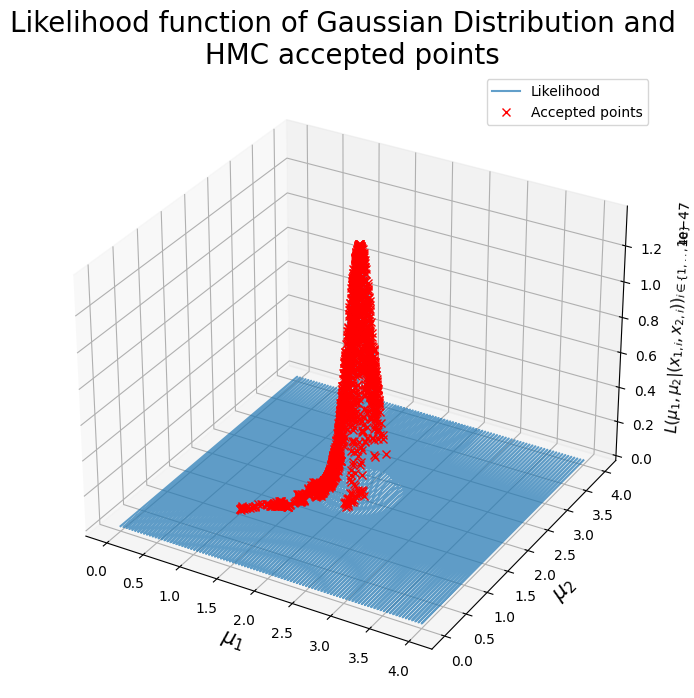

In [15]:
Grid = np.linspace(0, 4, 100)
x = []
y = []
z = []
r = len(Grid)

for g in Grid:
    y += list(Grid)
    x += [g]*r
    z += [Likeli.L([g, k]) for k in Grid]

fig = plt.figure(figsize=(8, 8), facecolor="white")

Gau = fig.add_subplot(projection="3d")
Gau.plot(x, y, z, alpha=0.7, label='Likelihood')
Gau.set_xlabel("$\mu_1$", fontsize=15)
Gau.set_ylabel("$\mu_2$", fontsize=15)
Gau.set_zlabel("$L(\mu_1, \mu_2| {(x_{1,i}, x_{2,i})})_{i \in \{1,..,40\}}$", fontsize=11)
Gau.set_title("Likelihood function of Gaussian Distribution and \n HMC accepted points", fontsize=20)

x = []
y = []
z = []
for i in theta_accept:
    x.append(i[0])
    y.append(i[1])
    z.append(Likeli.L([i[0], i[1]]))
Gau.plot(x, y, z, 'x', color='red', label='Accepted points')

Gau.legend()
# fig.tight_layout()
fig.show()

### Visualizing: Contour Plot

Taken from [Github](https://github.com/ethanluoyc/dhmc-jax/blob/master/notebooks/HMC.ipynb)

In [16]:
from numpyro import distributions

target_dist = distributions.MultivariateNormal(
    np.array([2, 2]), np.array([[1, 0], 
                           [0, 1.]]))

def target_log_prob_fn(state):
    return target_dist.log_prob(state)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


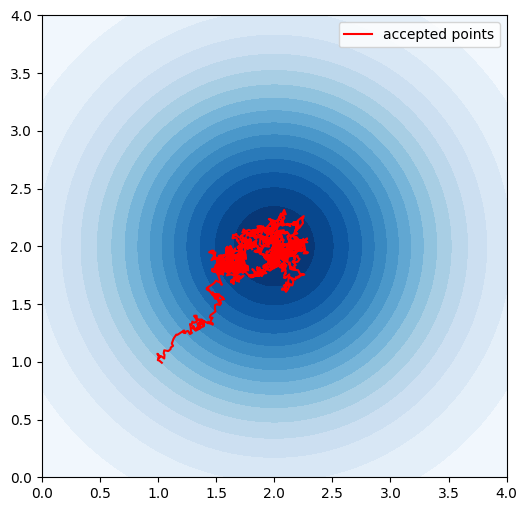

In [17]:
X, Y = np.meshgrid(np.linspace(0, 4, 100), 
                   np.linspace(0, 4, 100), 
                  )

_X = np.stack([X, Y]).reshape(2, -1)
probs = np.exp(target_log_prob_fn(_X.T).reshape((100, 100)))

fig, ax = plt.subplots(figsize=(6,6))
ax.contourf(
    X, Y,
    probs, 
    levels=15,
    cmap='Blues'
)

ax.plot(x, y, color='red', label='accepted points')

ax.legend()